In [1]:
import pandas as pd
import numpy as np
import string
import nltk
import re
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import NMF
from sklearn.cluster import SpectralClustering

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('movies_metadata_small.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9099 entries, 0 to 9098
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             9099 non-null   int64  
 1   adult                  9099 non-null   bool   
 2   belongs_to_collection  1674 non-null   object 
 3   budget                 9099 non-null   int64  
 4   genres                 9099 non-null   object 
 5   homepage               1974 non-null   object 
 6   id                     9099 non-null   int64  
 7   imdb_id                9099 non-null   object 
 8   original_language      9099 non-null   object 
 9   original_title         9099 non-null   object 
 10  overview               9087 non-null   object 
 11  popularity             9099 non-null   float64
 12  poster_path            9096 non-null   object 
 13  production_companies   9099 non-null   object 
 14  production_countries   9099 non-null   object 
 15  rele

In [3]:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')

In [4]:
df['combined_text'] = df['overview'].fillna('') + ' ' + df['tagline'].fillna('')

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower().strip()
    # Remove punctuation also numbers
    text = re.sub('[^a-z]+', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    # Re-join tokens into a string
    return ' '.join(lemmatized_text)

# Apply text preprocessing
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95)

# Fit and transform the processed text
tfidf_matrix = vectorizer.fit_transform(df['processed_text'])

In [5]:
tfidf_matrix.shape

(9099, 14630)

### K-Means

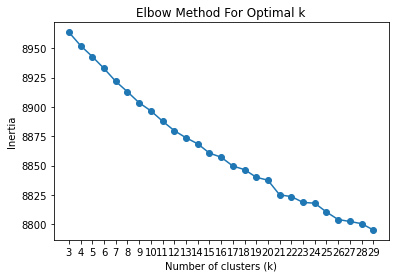

In [6]:
k_range = range(3, 30)

inertia = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(k_range)
plt.show()

In [7]:
kmeans = KMeans(n_clusters=10, init='k-means++', n_init=10, random_state=42)
# fit the model
kmeans.fit(tfidf_matrix)
# store cluster labels in a variable
labels = kmeans.labels_
feature_names = vectorizer.get_feature_names_out()

silhouette = silhouette_score(tfidf_matrix, labels)
silhouette

0.002792212079233209

In [8]:
centroids = kmeans.cluster_centers_

for i in range(len(centroids)):
    sorted_features = centroids[i].argsort()[::-1]
    top_features = feature_names[sorted_features[:10]]
    print(f"Cluster {i} top features:", top_features)

Cluster 0 top features: ['year' 'old' 'life' 'boy' 'father' 'one' 'new' 'find' 'mother' 'girl']
Cluster 1 top features: ['school' 'new' 'high' 'york' 'student' 'friend' 'girl' 'city' 'life'
 'teacher']
Cluster 2 top features: ['war' 'world' 'ii' 'american' 'soldier' 'nazi' 'german' 'story' 'civil'
 'vietnam']
Cluster 3 top features: ['love' 'fall' 'life' 'woman' 'story' 'man' 'young' 'two' 'find' 'meet']
Cluster 4 top features: ['man' 'murder' 'cop' 'killer' 'police' 'woman' 'detective' 'one' 'crime'
 'find']
Cluster 5 top features: ['film' 'documentary' 'director' 'life' 'story' 'movie' 'one' 'star'
 'based' 'directed']
Cluster 6 top features: ['family' 'life' 'father' 'son' 'home' 'brother' 'child' 'friend' 'mother'
 'young']
Cluster 7 top features: ['world' 'earth' 'evil' 'human' 'must' 'planet' 'alien' 'save' 'find'
 'one']
Cluster 8 top features: ['life' 'one' 'get' 'two' 'find' 'young' 'story' 'time' 'take' 'friend']
Cluster 9 top features: ['town' 'small' 'come' 'life' 'time' 'n

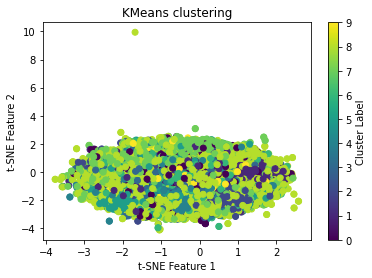

In [9]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())

# Plot the results
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans.labels_)
plt.title('KMeans clustering')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

### K-Means after SVD

In [10]:
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
X_lsa = lsa.fit_transform(tfidf_matrix)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Explained variance of the SVD step: 11.0%


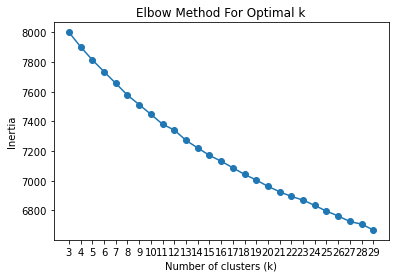

In [11]:
k_range = range(3, 30)

inertia = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_lsa)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(k_range)
plt.show()

In [12]:
kmeans = KMeans(n_clusters=12, init='k-means++', n_init = 10, random_state=42)
# fit the model
kmeans.fit(X_lsa)
# store cluster labels in a variable
labels = kmeans.labels_
feature_names = vectorizer.get_feature_names_out()

silhouette = silhouette_score(X_lsa, labels)
silhouette

0.032318900581101206

In [13]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

for i in range(len(original_space_centroids)):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{feature_names[ind]} ", end="")
    print()

Cluster 0: get back one way two new job help find go 
Cluster 1: family life father home child son year new one old 
Cluster 2: story true based tell life three one year world two 
Cluster 3: murder cop police killer detective crime case serial drug agent 
Cluster 4: school high student teacher girl friend year one new life 
Cluster 5: world war earth must human evil mission planet battle save 
Cluster 6: woman young man husband find life love one two meet 
Cluster 7: film documentary director life movie story star first directed one 
Cluster 8: new one find year two friend young take time town 
Cluster 9: life one year new find come time old change day 
Cluster 10: man young one find life wife take world year time 
Cluster 11: love fall life find meet story young two one new 


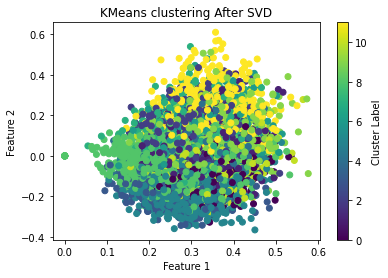

In [14]:
# Plot the results
plt.scatter(X_lsa[:, 0], X_lsa[:, 1], c=kmeans.labels_)
plt.title('KMeans clustering After SVD')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

#### Using t-SNE to plot the result

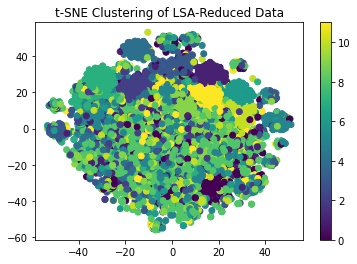

In [15]:
# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_tsne = tsne.fit_transform(X_lsa)

# Plot the clusters
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE Clustering of LSA-Reduced Data')
plt.colorbar(scatter)
plt.show()

### Spectral Clustering After SVD

In [16]:
spectral = SpectralClustering(n_clusters=12, assign_labels='discretize', random_state=42)

# Fit the model
spectral.fit(X_lsa)

# Store cluster labels
labels = spectral.labels_

# Attempt to calculate silhouette score (note: this might be computationally expensive for large datasets)
silhouette = silhouette_score(X_lsa, labels)

print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.02942745672088631


In [17]:
pseudo_centroids = []
for i in np.unique(labels):
    cluster_points = X_lsa[labels == i]
    pseudo_centroid = np.mean(cluster_points, axis=0)
    pseudo_centroids.append(pseudo_centroid)

original_pseudo_centroids = lsa[0].inverse_transform(pseudo_centroids)
pseudo_centroids = np.array(original_pseudo_centroids)

for i, centroid in enumerate(pseudo_centroids):
    print(f"Cluster {i}: ", end="")
    top_features_indices = centroid.argsort()[-10:][::-1]
    for ind in top_features_indices:
        print(f"{feature_names[ind]} ", end="")
    print()

Cluster 0: family father mother son year home old child daughter brother 
Cluster 1: new york city year life world get take friend one 
Cluster 2: get murder cop police agent killer crime take go detective 
Cluster 3: war world ii american nazi soldier german man battle life 
Cluster 4: life man find time one year change day come love 
Cluster 5: town find evil small earth must human time adventure alien 
Cluster 6: school high girl student friend teacher year college boy best 
Cluster 7: story true based tell life year three two one american 
Cluster 8: one two man year night friend get day find time 
Cluster 9: love fall find meet life two story friend relationship young 
Cluster 10: film documentary movie director star life show comedy first people 
Cluster 11: woman man young find murder husband wife becomes one take 


#### Using t-SNE to plot the result

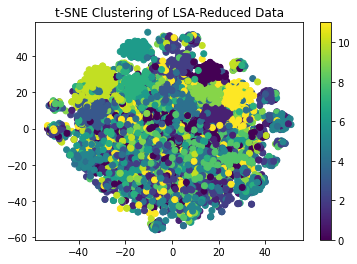

In [18]:
# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_tsne = tsne.fit_transform(X_lsa)

# Plot the clusters
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE Clustering of LSA-Reduced Data')
plt.colorbar(scatter)
plt.show()

### K-means after NMF

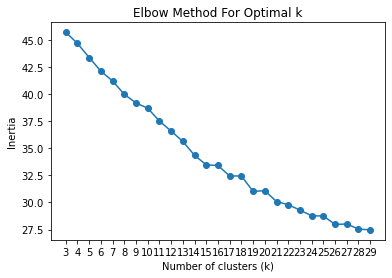

In [19]:
nmf = NMF(n_components=100, random_state=42)
X_nmf = nmf.fit_transform(tfidf_matrix)

k_range = range(3, 30)

inertia = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_nmf)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(k_range)
plt.show()

Silhouette Score: 0.13113820039365873


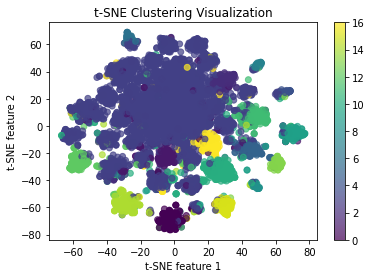

In [23]:
kmeans = KMeans(n_clusters=17, init='k-means++', n_init = 10, random_state=42)
labels = kmeans.fit_predict(X_nmf)

silhouette_avg = silhouette_score(X_nmf, labels)
print(f'Silhouette Score: {silhouette_avg}')

# t-SNE for Visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_nmf)

# Plot
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('t-SNE Clustering Visualization')
plt.colorbar(scatter)
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

In [21]:
# Count the number of movies in each cluster
cluster_counts = np.bincount(labels)

# Print the count of movies in each cluster
for i in range(len(cluster_counts)):
    print(f"Cluster {i}: {cluster_counts[i]} movies")

Cluster 0: 266 movies
Cluster 1: 181 movies
Cluster 2: 204 movies
Cluster 3: 63 movies
Cluster 4: 274 movies
Cluster 5: 315 movies
Cluster 6: 244 movies
Cluster 7: 205 movies
Cluster 8: 54 movies
Cluster 9: 184 movies
Cluster 10: 226 movies
Cluster 11: 211 movies
Cluster 12: 272 movies
Cluster 13: 50 movies
Cluster 14: 6079 movies
Cluster 15: 271 movies


In [22]:
nmf_components = nmf.components_

# Get the feature names from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Number of top words you want to print for each cluster
n_top_words = 10

# For each cluster center in KMeans
for cluster_idx in range(kmeans.n_clusters):
    # Get the indices of the top features for this cluster
    top_feature_indices = nmf_components[cluster_idx].argsort()[-n_top_words:][::-1]
    
    # Get the top words
    top_words = [feature_names[i] for i in top_feature_indices]
    
    # Print the cluster number and its top words
    print(f"Cluster {cluster_idx}: {' '.join(top_words)}")

Cluster 0: way along stand learn across learns vega meet encounter becoming
Cluster 1: love romance falling relationship lover affair beautiful triangle romantic sex
Cluster 2: film director directed feature follows classic first making star short
Cluster 3: woman husband meet affair beautiful married every another sexual men
Cluster 4: father estranged dad looking help discovers priest money kid holy
Cluster 5: fall meet first married rise guy apart beautiful business artist
Cluster 6: life career live sometimes turned around upside meaning real start
Cluster 7: new york start orleans form jersey apartment deal upstate paul
Cluster 8: get involved caught even ready trying guy chance married help
Cluster 9: year later first seven ten ago earlier twenty eight five
Cluster 10: school high teacher senior popular football prom class student classmate
Cluster 11: world ii around save top changed imagination beyond different powerful
Cluster 12: man hit demon kill black ordinary nature dange

In [27]:
umap_df = pd.read_csv('umap_df.csv')
umap_df = umap_df.iloc[:, 1:]
umap_df = umap_df.drop_duplicates(subset='id', keep='first')

In [28]:
df['cluster_label'] = labels
df = df.drop_duplicates(subset='id', keep='first')
df['id'].nunique()

9082

In [29]:
movies_features = pd.merge(umap_df, df[['id', 'cluster_label']], on = 'id', how = 'inner')

cluster_dummies = pd.get_dummies(movies_features['cluster_label'], prefix='cluster')
movies_features = pd.concat([movies_features, cluster_dummies], axis=1)
movies_features = movies_features.drop("cluster_label", axis='columns')

movies_features.to_csv('movies_features.csv')

### Hashing Vectorization (BAD!)

In [30]:
lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=200, random_state=0),
    Normalizer(copy=False),
)

X_hashed_lsa = lsa_vectorizer.fit_transform(df['processed_text'])

In [31]:
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=3, random_state=42)
# fit the model
kmeans.fit(X_hashed_lsa)
# store cluster labels in a variable
labels = kmeans.labels_

silhouette = silhouette_score(X_hashed_lsa, labels)
silhouette

0.01475457831166621

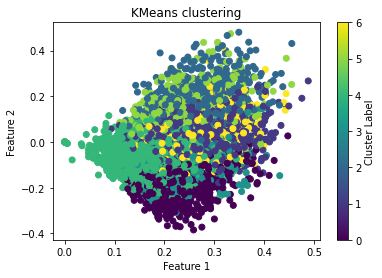

In [32]:
# Plot the results
plt.scatter(X_hashed_lsa[:, 0], X_hashed_lsa[:, 1], c=kmeans.labels_)
plt.title('KMeans clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

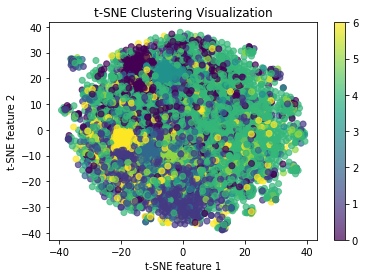

In [33]:
# t-SNE for Visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_hashed_lsa)

# Plot
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('t-SNE Clustering Visualization')
plt.colorbar(scatter)
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()